<a href="https://colab.research.google.com/github/yessimico/ToxicCommentClassification-NLP-Project-/blob/main/BadComments_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
nltk.download('punkt')
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
df = pd.read_csv("/content/drive/MyDrive/labeled.csv")

In [5]:
df.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


In [6]:
df["toxic"] = df["toxic"].astype(int)

In [7]:
df["toxic"].value_counts() #the relation of toxic and non-toxic examples as 1 to 2, actually not bad

,count
toxic,
0,9586
1,4826


In [8]:
for c in df[df["toxic"] == 1]["comment"].head(5): #checking if toxic examples is indeed bad (yes)
  print(c)


Верблюдов-то за что? Дебилы, бл...

Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

Собаке - собачья смерть

Страницу обнови, дебил. Это тоже не оскорбление, а доказанный факт - не-дебил про себя во множественном числе писать не будет. Или мы в тебя верим - это ты и твои воображаемые друзья?

тебя не убедил 6-страничный пдф в том, что Скрипалей отравила Россия? Анализировать и думать пытаешься? Ватник что ли?)



In [9]:
for c in df[df["toxic"] == 0]["comment"].head(5): #checking if non-toxic examples is indeed not bad (actually there is bad words in 5th example, so we must know that the data is not ideal, it will affect model)
  print(c)

В шапке были ссылки на инфу по текущему фильму марвел. Эти ссылки были заменены на фразу Репортим брипидора, игнорируем его посты. Если этого недостаточно, чтобы понять, что модератор абсолютный неадекват, и его нужно лишить полномочий, тогда эта борда пробивает абсолютное дно по неадекватности.

Почитайте посты у этого автора,может найдете что нибудь полезное. Надеюсь помог) https: pikabu.ru story obyichnyie budni dezsluzhbyi 4932098

Про графику было обидно) я так то проходил все серии гта со второй части по пятую, кроме гта 4. И мне не мешала графика ни в одной из частей. На компе у меня было куча видеокарт. Начиная с 32мб RIVA TNT и заканчивая 2Гб 560Ti на которой я спокойно играю который год в танки, гта5, ведьмака3 купил на распродаже и начал проходить. Да, не на ультрах. С пониженными текстурами. И не мешает. Я не понимаю дрочева на графике, требовать графику уровня плойки 4 минимум. Мне надо чтобы глаза не резало, только и всего. По поводу управления, мне не хватает переходника

In [10]:
train_df, test_df = train_test_split(df, test_size = 500)

In [11]:
test_df.shape #checking if test size indeed 500

(500, 2)

In [12]:
test_df["toxic"].value_counts() #checking if toxic and non-toxic examples are splitted adequately

,count
toxic,
0,330
1,170


In [13]:
train_df["toxic"].value_counts()

,count
toxic,
0,9256
1,4656


In [27]:
nltk.download('stopwords')
russian_stopwords = stopwords.words("russian")

model_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
                lowercase=True, #lowercasing everything to be insensitive to register
                stop_words=russian_stopwords, #getting rid of russian_stopwords
                ngram_range=(1, 2), #model sees not only words but, phrases
                min_df=5,#removes rare words
                max_df=0.9
                )),

    ("model", LogisticRegression(
                max_iter=1000,
                n_jobs=-1,
                random_state = 1))
    ])

model_pipeline.fit(df["comment"], df["toxic"])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, min_df=5, ngram_range=(1, 2),
                                 stop_words=['и', 'в', 'во', 'не', 'что', 'он',
                                             'на', 'я', 'с', 'со', 'как', 'а',
                                             'то', 'все', 'она', 'так', 'его',
                                             'но', 'да', 'ты', 'к', 'у', 'же',
                                             'вы', 'за', 'бы', 'по', 'только',
                                             'ее', 'мне', ...])),
                ('model',
                 LogisticRegression(max_iter=1000, n_jobs=-1, random_state=1))])

In [28]:
model_pipeline.predict(["сегодня вечером приду, пожарим мясо и тебя"]) #just checking if model predicts my input (yes)

array([0])

In [29]:
model_pipeline.predict(["слушай, не пойти ли тебе нафиг отсюда?"]) #predicts correctly

array([1])

In [31]:
y_pred = model_pipeline.predict(test_df["comment"]) #predicting test sample

In [53]:
prec = precision_score(test_df["toxic"], y_pred) #shows how precise the prediction is
rec = recall_score(test_df["toxic"], y_pred) #shows which part predicted of overall toxic comments

print(prec, rec) #we need min 95% precision score and max recall possible with this precision

0.9214285714285714 0.7588235294117647


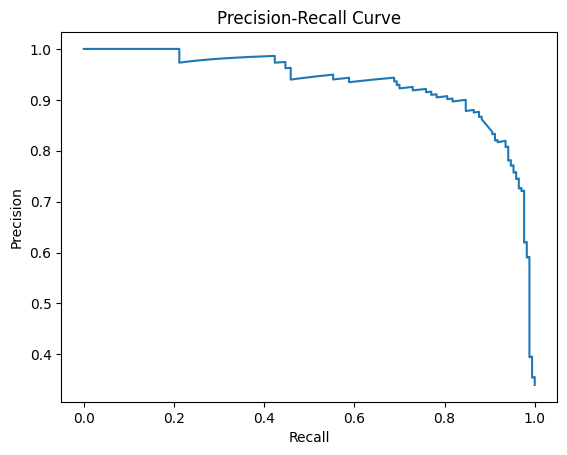

In [57]:
proba = model_pipeline.predict_proba(test_df["comment"])[:, 1]
precision, recall, thresholds = precision_recall_curve(test_df["toxic"], proba) #lets look how precision_recall_curve looks like and find precision with 0.95 value

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

In [58]:
np.where(precision > 0.95) #returns indexes where precision grater than 0.95, so we can find threshold at this value

(array([409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421,
        422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434,
        435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447,
        448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460,
        461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473,
        474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486,
        487, 488, 489, 490]),)

In [59]:
thresholds[409]

np.float64(0.6407196369279101)

In [60]:
threshold = 0.64
y_pred_new = (proba >= threshold).astype(int) # now predictions with probabilities higher than 40% will count as toxic

new_prec = precision_score(test_df["toxic"], y_pred_new)
new_rec = recall_score(test_df["toxic"], y_pred_new)

print(new_prec, new_rec) #better result

0.9512195121951219 0.4588235294117647


In [103]:
param_grid = { #lets try use grid search if he can find better params, if not then OK
    "model__C": [0.1, 1, 5, 10] #how much do we allow the model to believe the words. the greater value of C the more model fits, but risks to overfit
}

In [104]:
grid = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    cv=3, #cross validation parts
    n_jobs=-1, #activating full power of computer
    verbose=2
)

grid.fit(train_df["comment"], train_df["toxic"])

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_df=0.9, min_df=5,
                                                        ngram_range=(1, 2),
                                                        stop_words=['и', 'в',
                                                                    'во', 'не',
                                                                    'что', 'он',
                                                                    'на', 'я',
                                                                    'с', 'со',
                                                                    'как', 'а',
                                                                    'то', 'все',
                                                                    'она',
                                                                    'так',
                                                                    'его', 'но',
                                                                    'да', 'ты',
                                                                    'к', 'у',
                                                                    'же', 'вы',
                                                                    'за', 'бы',
                                                                    'по',
                                                                    'только',
                                                                    'ее', 'мне', ...])),
                                       ('model',
                                        LogisticRegression(max_iter=1000,
                                                           n_jobs=-1,
                                                           random_state=1))]),
             n_jobs=-1, param_grid={'model__C': [0.1, 1, 5, 10]}, verbose=2)

In [105]:
grid.best_params_ #getting best params from all combination

{'model__C': 5}

In [106]:
best_model = grid.best_estimator_ #getting best model

Text(0, 0.5, 'precision')

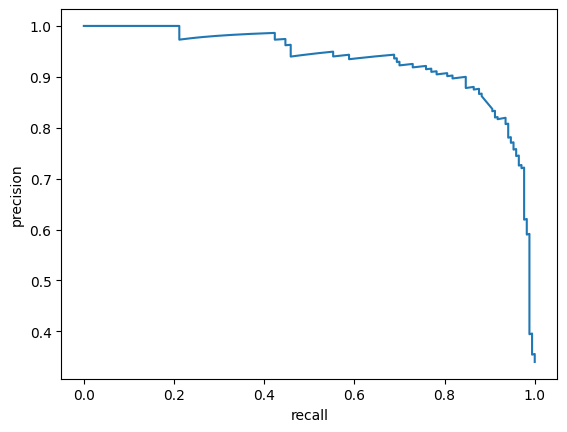

In [107]:
new_proba = best_model.predict_proba(test_df["comment"])[:,1]  #doing again previous steps to check result

new_precision, new_recall, new_thresholds = precision_recall_curve(test_df["toxic"], new_proba)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("recall")
plt.ylabel("precision")

In [148]:
np.where(new_precision > 0.95)

(array([428, 429, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441,
        442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454,
        455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467,
        468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480,
        481, 482, 483, 484, 485, 486, 487, 488]),)

In [149]:
new_thresholds[428]

np.float64(0.8710089546458417)

In [150]:
new_threshold = 0.87 #actually this number we got from new threshold and already seems to be not good
y_pred_new = (proba >= new_threshold).astype(int)

new_prec = precision_score(test_df["toxic"], y_pred_new)
new_rec = recall_score(test_df["toxic"], y_pred_new)

print(new_prec, new_rec)
#better precision, but worse recall. we dont need to maximize the precision,
#we need only to reach .95 value and maximize recall, so we will stay at previous model.
#we did smth unnecessary, but we made sure that we got good result from our previous model.

1.0 0.11764705882352941


In [151]:
import joblib

final_model = model_pipeline #threshold = 0.64
joblib.dump(final_model, "toxic_model.pkl")

['toxic_model.pkl']